Based on https://github.com/James-Jagielski/7-bit-D-A-converter-MP4-MADVLSI/blob/main/schematics/simulations/plot_dac_mc.ipynb with permission of repo owners

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from si_prefix import si_format

In [41]:
n_bits = 7
mc_simulations = []
nano = 1e-9
results_dir = "./mc"
ideal_step_size = 9e-06/(2**7)

[7.03125e-08, 0]
max allowable error 3.515625e-08
max error 4.5989134700000004e-07
variance of error 4.5989134700000004e-07
[-9.99993431e-01 -9.99559097e-01 -1.44395891e-01  3.85664297e-01
 -7.49005938e-02  2.66835570e-01  7.31374507e-02  4.67349959e-01
 -1.94152932e-01  1.95025508e-01 -1.75634204e-02  4.06922724e-01
 -1.43335225e-01  2.97962027e-01  6.83786951e-02  5.63871289e-01
 -3.36450702e-01  1.48276338e-01 -1.09415822e-01  4.07047680e-01
 -2.56572302e-01  2.75058631e-01  4.56533333e-04  5.83045262e-01
 -3.67691662e-01  2.09702684e-01 -9.02553600e-02  5.21798116e-01
 -2.54593280e-01  3.74542791e-01  5.53203200e-02  6.75827769e-01
 -5.58704213e-01  1.13025991e-01 -2.35793920e-01  4.62525867e-01
 -4.26721849e-01  2.85045476e-01 -7.91863467e-02  6.80873244e-01
 -5.58101476e-01  1.96264249e-01 -1.91358862e-01  5.93684764e-01
 -3.99105280e-01  4.01781476e-01 -3.88138667e-03  8.51935004e-01
 -6.94373262e-01  1.50513920e-01 -2.82646329e-01  5.88231964e-01
 -5.13641529e-01  3.71154347e-0

Text(0, 0.5, 'lsbs of error')

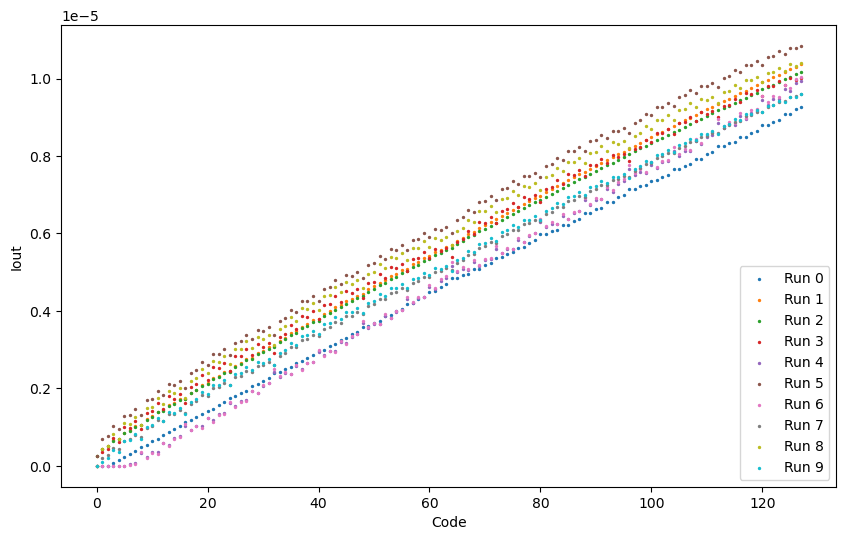

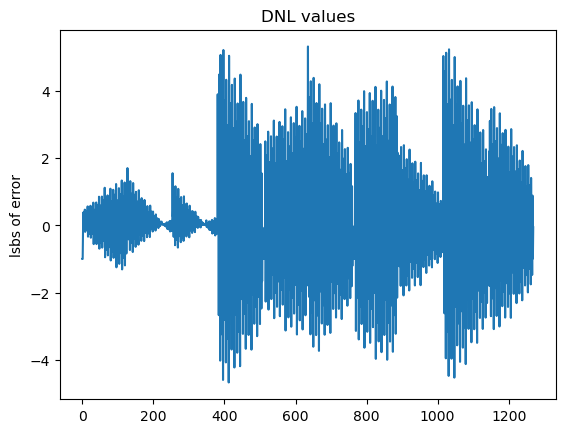

In [42]:
for filename in os.listdir(results_dir):
    df = pd.read_csv(os.path.join(results_dir, filename), delimiter = "\s+")
    # print(df.head(3))
    #print(df)
    # df["code"] = df["v(b0)"] * 0 # init column to all 0s
    # for bit in range(n_bits):
    #     # df["code"] = df["code"] + (df[f"v{bit}"] > .5*df["vdd"]) * 2 ** (n_bits - bit - 1)
    #     df["code"] = df["code"] + (df[f"v(b{bit})"] > .5*1.8) * 2 ** (n_bits - bit - 1) #WHAT DOES THIS DO
    #     df.drop(f"v(b{bit})", axis = "columns", inplace = True)
    df["code"] = range(128)
    df.rename({"i(vi_out)": "Iout"}, axis = "columns", inplace = True)
    # print(df.head(10))
    mc_simulations.append(df)

tdf = pd.concat(mc_simulations)
plt.figure(figsize = (10, 6))
plt.xlabel("Code")
plt.ylabel("Iout")

#z = np.polyfit(tdf["code"], tdf["Iout"], 1)
z = [ideal_step_size,0]
print(z)
p = np.poly1d(z)

errors = np.subtract(p(tdf["code"]),tdf["Iout"])

print("max allowable error", np.mean( np.subtract( p(range(1,128)) ,p(range(0,127)) ) )/2 )
print("max error",np.max(errors))
print("variance of error",np.max(errors))

dnl  = []
dnl_multi = []
for df_simulation in mc_simulations:
    sorted = df_simulation.sort_values("code")
    current =   np.subtract(np.divide(
                    np.subtract(
                         list(sorted["Iout"])[1:],list(sorted["Iout"])[:-1]
                    ),ideal_step_size),1)
    print(current)
    cc = list(current) #list(np.vstack((current,dnl)).T)
    #print(len(cc))
    dnl_multi.append(cc)
    for line in cc:
        dnl.append(line)#dnl.append(float(max(line,key=abs)))
    #print(dnl)

inl = np.sum(dnl)



# plt.plot(range(128),p(range(128)),"k--", label = "trendline", linewidth = .5)

for i, df_simulation in enumerate(mc_simulations):
    # plt.plot(np.array(df_simulation["code"]), np.array(df_simulation["Iout"]), linewidth = 1, label = f"Run {i}")
    plt.scatter(np.array(df_simulation["code"]), np.array(df_simulation["Iout"]), s = 2, label = f"Run {i}")
plt.legend(loc = "lower right")

plt.figure()
plt.plot(range(len(dnl)), dnl)
plt.title("DNL values")
print("max overall dnl",max(dnl,key=abs)) 
print("loc of max value",dnl.index(max(dnl,key=abs)))
print("INL" , inl)
plt.ylabel("lsbs of error")